In [4]:
import os
from os.path import expanduser
import socket
import sys
import glob

# BELOW IS SYSTEM/PATH CONFIGURATION #
my_home = expanduser("~")
running_system = socket.gethostname()
# Configure machine's names here #
systemHLRN = 'blogin1'
systemLOCAL = 'Laurents-MacBook-Pro.local'
my_home = expanduser("~")
# Define local pass #
wd_path = '/home/hbkoziel/pyfesom/'
save_path = wd_path+'/figures/Arc12/FINAL/'

#sys.path.append("codes/modules") # add custom Vibe 's modules
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')
#########################################

In [6]:
import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time

import xarray as xr
import pandas as pd
sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap

In [7]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/home/hbkoziel/pyfesom/data/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'VNF'
first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'

data_path  = '/scratch/usr/hbkoziel/'+runid+'/netcdf/'

/home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh


In [8]:
print('loading index...')
df = pd.read_csv('/home/hbkoziel/awi-models/data/mesh/meshArc4.5/bioregion_index_latlon.csv', delimiter=',',header=0)
print('LOADING DONE')
df.sort_values(by ='Unique_ID',inplace=True)
index = df["Unique_ID"]
index_unique = df.Unique_ID.unique().tolist()
index_unique.pop(-1)
print('SORTING...')
names = df.Name.unique().tolist()
names.pop(-1)
names[3]='Beaufort Sea - shelf'
names[4]='Amundsen-Viscount'
names.append('All Arctic Ocean (>66N)')
print('CLEANING DONE...')
ind_bio = df.full_index[df.Unique_ID == 24]

loading index...
LOADING DONE
SORTING...
CLEANING DONE...


In [9]:
ncfile      = meshpath+'Arc4.5.initial.mesh.diag.nc'
f           = Dataset(ncfile, 'r')
NodalAreaModel = f.variables['cluster_area'][:]

In [10]:
ind_fram = (np.array(mesh.x2>-10) & np.array(mesh.x2<10) & np.array(mesh.y2>80) & np.array(mesh.y2<85))
ind_east = (np.array(mesh.x2<115) & np.array(mesh.x2>85) & np.array(mesh.y2<88) & np.array(mesh.y2>85))

In [11]:
# tracername = 'cur50m'
# time = pd.date_range('1985-01-01', freq="MS", periods= 12*len(np.arange(1985,2016,1)))
# data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
# data['time'] = time

# CUR_sel = data.cur50m.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
# CUR_sel = CUR_sel.compute()

# # CUR_march = CUR_sel[data['time.month']==3]
# # CUR_march = CUR_march.compute()

# CUR_yrly = CUR_sel.resample(time = 'Y').mean(dim = 'time')
# CUR_yrly = CUR_yrly.compute()

# #ind_curr = np.array(CUR_sept_mean >= 0.03)

# # pf = np.polyfit(years, CUR_sept, 1)
# # CUR_trend = pf[0]

In [12]:
tracername = 'VNF'
first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
dates = pd.date_range('1985', freq="MS", periods= 12*len(np.arange(1985,2016,1)))
#time = pd.date_range('1985-01-01', freq="MS", periods= 12*len(np.arange(1985,2016,1)))
data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
data['time'] = dates
ANPP_sel = data.w.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
ANPP_sel = ANPP_sel.compute()
#ANPP_sel = ANPP_sel.where(ANPP_sel > 0)

ANPP_yrly = ANPP_sel.resample(time = 'Y').mean(dim = 'time')
ANPP_yrly = ANPP_yrly.compute()
 

ts_yerm  = np.sum(ANPP_yrly[:,ind_east]*NodalAreaModel[ind_east],axis=1)/np.sum(NodalAreaModel[ind_east])

#ts_yerm = ts_yerm / np.std(ANPP_yrly[:,ind_curr])
pf1 = np.polyfit(years, ts_yerm, 1)
ANPP_trend31 = pf1[0]


In [23]:
from utils import linreg
#from utils import ols
#ols = ols(ANPP_yrly[:,ind_east[1]], 'slope')
for i in range(0,len(mesh.x2)+1):
    smry = linreg(years, np.array(ANPP_yrly[:,i]))
    pval[i] = smry.pvalues[1]

/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


NameError: name 'pval' is not defined

False


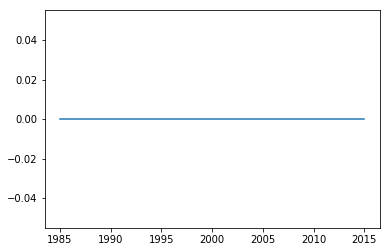

In [35]:
i = 2
print ind_east[i]
plt.plot(years, np.array(ANPP_yrly[:,ind_east[100]]))

In [ ]:
plt.style.use('seaborn')
plt.style.use('seaborn-talk')
plt.plot(years,ts_yerm, color = 'tab:blue')
plt.title('upward vertical fluxes')

In [ ]:
smry.pvalues

In [ ]:
import pyfesom as pf

data, elem_no_nan = pf.get_data(ANPP_trend,mesh,0)

In [ ]:
print np.mean(ANPP_trend[ind_east])

In [ ]:
#fig = plt.figure()
fig = plt.figure(figsize=(8, 8), facecolor='w', edgecolor='k')
#fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(15, 15), facecolor='w', edgecolor='k')

#axs[0]      = fig.add_subplot(211)
contours = np.arange(-5, 5.1, .1)
m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
#map.drawcoastlines()
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
#eps=(contours.max()-contours.min())/100.
#data2[data2<=contours.min()]=contours.min()+eps
#data2[data2>=contours.max()]=contours.max()-eps
im=plt.tricontourf(x, y, elem_no_nan, data, levels=contours, cmap=cmap.cm.balance, extend='both')
plt.annotate('1985-2015', xy=(0.6, 0.9), xycoords='axes fraction', fontsize = 20,
                     fontweight = 'bold', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

# subplot for colorbar
#cbar = fig.colorbar(im, ax=axs[:1], shrink=0.5, location='bottom')
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
label = 'VNF'
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
# cbar.ax.tick_params(labelsize=16) 
# cbar.set_label(label, fontsize=16)


lat_1 = 85
lat_2 = 88
lon_1 = 85
lon_2 = 115

lati = np.append(np.linspace(lat_1,lat_2,10),np.ones(10)*lat_2)
lati = np.append(lati,np.linspace(lat_2,lat_1,10))
lati = np.append(lati,np.ones(10)*lat_1)

loni = np.append(np.ones(10)*lon_1,np.linspace(lon_1,lon_2,10))
loni = np.append(loni,np.ones(10)*lon_2)
loni = np.append(loni,np.linspace(lon_2,lon_1,10))

xi, yi = m(loni, lati)
plt.plot(xi,yi,'k',lw=2)


#plt.savefig(save_path+'FIG9.png', dpi = 300, bbox_inches='tight') 

In [ ]:
ind_fram = (np.array(mesh.x2<115) & np.array(mesh.x2>85) & np.array(mesh.y2<88) & np.array(mesh.y2>85))
ANPP_trend.size
trendX = np.empty(ANPP_trend.size)
trendX[:] = np.nan
trendX[ind_fram]=ANPP_trend[ind_fram]
data, elem_no_nan = pf.get_data(trendX,mesh,0)

#fig = plt.figure()
fig = plt.figure(figsize=(8, 8), facecolor='w', edgecolor='k')
#fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(15, 15), facecolor='w', edgecolor='k')

#axs[0]      = fig.add_subplot(211)
contours = np.arange(-5, 5.1, .1)
m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
#map.drawcoastlines()
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
#eps=(contours.max()-contours.min())/100.
#data2[data2<=contours.min()]=contours.min()+eps
#data2[data2>=contours.max()]=contours.max()-eps
im=plt.tricontourf(x, y, elem_no_nan, data, levels=contours, cmap=cmap.cm.balance, extend='both')
plt.annotate('1985-2015', xy=(0.6, 0.9), xycoords='axes fraction', fontsize = 20,
                     fontweight = 'bold', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

# subplot for colorbar
#cbar = fig.colorbar(im, ax=axs[:1], shrink=0.5, location='bottom')
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
label = 'VNF'
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
# cbar.ax.tick_params(labelsize=16) 
# cbar.set_label(label, fontsize=16)


lat_1 = 85
lat_2 = 88
lon_1 = 85
lon_2 = 115

lati = np.append(np.linspace(lat_1,lat_2,10),np.ones(10)*lat_2)
lati = np.append(lati,np.linspace(lat_2,lat_1,10))
lati = np.append(lati,np.ones(10)*lat_1)

loni = np.append(np.ones(10)*lon_1,np.linspace(lon_1,lon_2,10))
loni = np.append(loni,np.ones(10)*lon_2)
loni = np.append(loni,np.linspace(lon_2,lon_1,10))

xi, yi = m(loni, lati)
plt.plot(xi,yi,'k',lw=2)


#plt.savefig(save_path+'FIG9.png', dpi = 300, bbox_inches='tight') 